# Koneoppiminen

Seuraavaksi pyritään ennustamaan asunnon hintaa käyttämällä muutamia itsenäisiä muuttujia. 

Halutessasi voit tutustua muistioon oheisen [repositorion](https://github.com/tuomijal/TLO-32410/) kautta, josta on tarjolla myös interaktiivinen [Binder-versio](https://mybinder.org/v2/gh/tuomijal/TLO-32410/master).

In [7]:
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
import numpy as np

%matplotlib inline

# up figure resolution
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 150

import warnings
warnings.filterwarnings('ignore')

import pyvista as pv
from pyvista import set_plot_theme
set_plot_theme('document')

from pyprojroot import here
import geopy.distance

In [8]:
ld_backup = pd.read_csv(f"http://data.insideairbnb.com/spain/catalonia/barcelona/2020-02-16/data/listings.csv.gz")

In [9]:
ld = ld_backup.copy()

# convert price dtype
ld['price'] = ld.price.str[1:].replace("$", '')
ld['price'] = ld.price.str.replace(',', '')
ld['price'] = ld.price.astype(float)

# log of price
ld['price_log'] = ld.price.apply(np.log)
ld['price_log'] = ld.price_log.replace([np.inf, -np.inf], np.nan)
ld['price_log'] = ld.price_log.fillna(value=0)


# calculcate deal index
ld['deal_index'] = ld.review_scores_rating / ld.price

# calculate distance from Plaza de Catalonia
def get_distance(apartment_coords):
    catalonia_square_coords = (41.386710, 2.169401)
    distance = geopy.distance.vincenty(catalonia_square_coords, apartment_coords).km
    return distance

ld['distance_from_catalonia_square'] = ld[['latitude', 'longitude']].apply(get_distance, raw=True, axis=1)

# dropna
ld = ld.dropna(subset=['deal_index'])

## Lineaarinen regressio

Vastemuuttuja on jatkuva, joten lineaarinen regressio on luonteva ensilinjan algoritmi. Tehdään koeporaus käyttämällä seuraavia piirteitä:

- kylpyhuoneiden määrä
- makuuhuoneiden määrä
- majottuvien määrä
- naapurustoryhmä
- sänkyjen määrä
- etäisyys katalonia aukiolta

Rajataan kohteisiin, joiden hinta < 1500 usd/yö koska tämän yläpuolella on selkeitä outliereita. Käytetään 10-fold ristivalidaatiota.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

lr = LinearRegression()

data = ld.copy()

# filters
data = data[data.price < 1500]
data = data[data.property_type == 'Apartment']

# select columns to model
data = data[['bathrooms', 
             'bedrooms', 
             'price', 
             'accommodates', 
             'neighbourhood_group_cleansed', 
             'beds', 
             'distance_from_catalonia_square']]
data = data.dropna()

#dummify
categorical_columns = ['neighbourhood_group_cleansed']
dummies = pd.get_dummies(data[categorical_columns])
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns=categorical_columns)


X = data.drop(columns=['price'])
y = data.price

y_pred = cross_val_predict(lr, X, y, cv=10)

mae = np.abs(y_pred - y)
mae.describe()

count    13361.000000
mean        42.739581
std         71.027224
min          0.000000
25%         10.593750
50%         23.890625
75%         48.500000
max       1061.109375
Name: price, dtype: float64

In [16]:
r2_score(y, y_pred)

0.3407465628336307

In [18]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate mean absolute percentage error based on two input vectors.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
mean_absolute_percentage_error(y, y_pred)

57.558790529726444

Text(0.5, 0, 'measured')

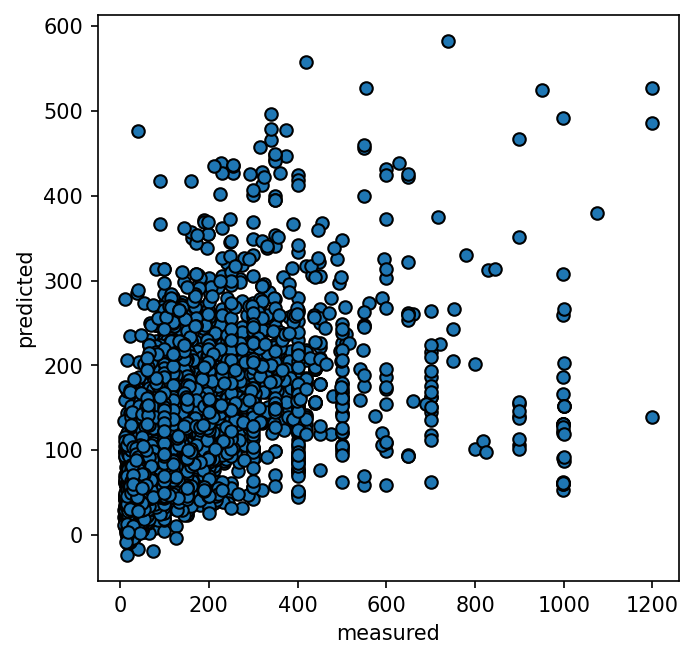

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
ax.set_ylabel('predicted')
ax.set_xlabel('measured')

Absoluuttinen keskivirhe (MAE) on 42, absoluuttinen prosentuaalinen keskivirhe (MAPE) 58 % ja R2-tarkkuus 0.34. Edellä kuvatut piirteet siis ennustavat siis varsin huonosti asunnon hintaa eikä tällä mallilla ole käytännön arvoa. Ohessa tuli kuitenkin demostroitua monimuuttujaregressions käyttöä ja vaadittavat manipulaatiot itsenäisten muuttujien osalta. Jatkotyönä tulee selvittää muiden piirteiden arvo mallin tarkkuuden parantamisessa.

2/3 p